In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.regularizers import l2


from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report,accuracy_score

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

## Work directory

In [2]:
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

<a id="section-one"></a>
# Data with EDA

In [3]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [4]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
image_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
image_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


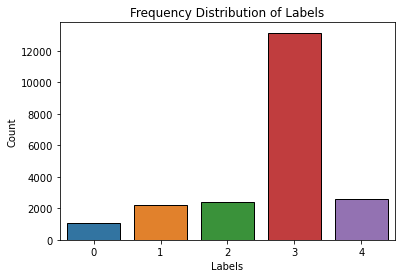

In [6]:
sns.countplot(image_labels.label, edgecolor = 'black')
plt.title('Frequency Distribution of Labels')
sns.set_style("white")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)"

## Photos of dominant class

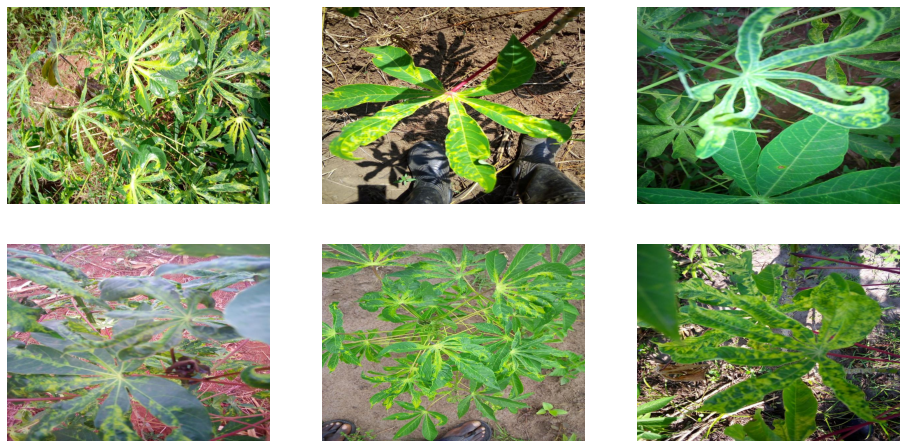

In [7]:
sample = image_labels[image_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## Photos of healthy plants

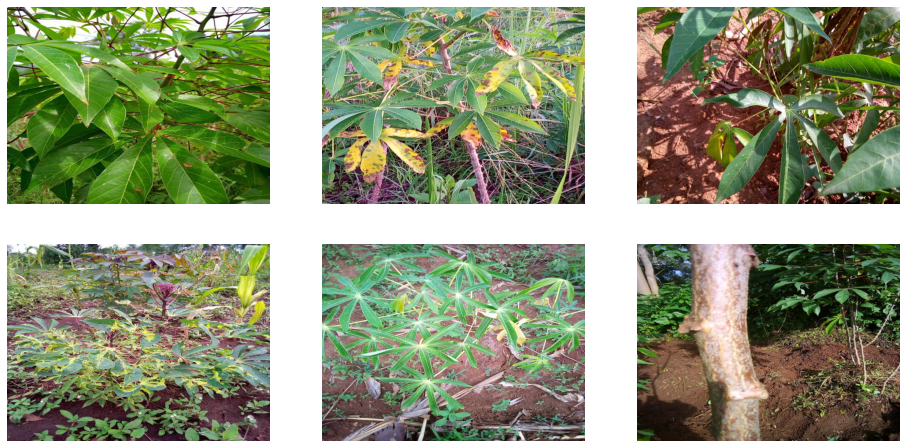

In [8]:
sample = image_labels[image_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

<a id="section-two"></a>
# The baseline level of accuracy

In [9]:
y_pred = [3] * len(image_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, image_labels.label))

The baseline accuracy: 0.615


<a id="section-three"></a>
# Modeling

In [10]:
# The TRAIN/VALID split is performing in the generator directly.

train_labels, test_labels = train_test_split(image_labels, train_size = 0.9, shuffle = True,
                               random_state = 42)

In [11]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 32
TARGET_SIZE = 512

In [12]:
train_labels.label = train_labels.label.astype('str')

train_gen = ImageDataGenerator(validation_split = 0.2) 

train_generator=train_gen .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 15406 validated image filenames belonging to 5 classes.
Found 3851 validated image filenames belonging to 5 classes.


In [13]:
test_labels.label = test_labels.label.astype('str')

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=os.path.join(WORK_DIR, "train_images"),
    x_col="image_id",
    y_col="label",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',   #category
    shuffle=False  
)

Found 2140 validated image filenames belonging to 5 classes.


In [14]:
def create_model():
    model = models.Sequential([          
            Conv2D(filters=32, kernel_size=(5, 5), padding='Same',activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
            Conv2D(filters=32, kernel_size=(5, 5), padding='Same',activation='relu'),
            MaxPool2D(pool_size=(2, 2)),

            Conv2D(filters=64, kernel_size=(3, 3), padding='Same',activation='relu'),
            Conv2D(filters=64, kernel_size=(3, 3), padding='Same',activation='relu'),
            MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Dropout(0.2),

            Conv2D(64, (3, 3), activation='relu',padding="same",kernel_regularizer=l2(0.001)),
            layers.GlobalAveragePooling2D(),


            Flatten(),
            Dense(256, activation="relu"),
            layers.Dropout(0.3),
            Dense(5, activation='softmax')])

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [15]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0

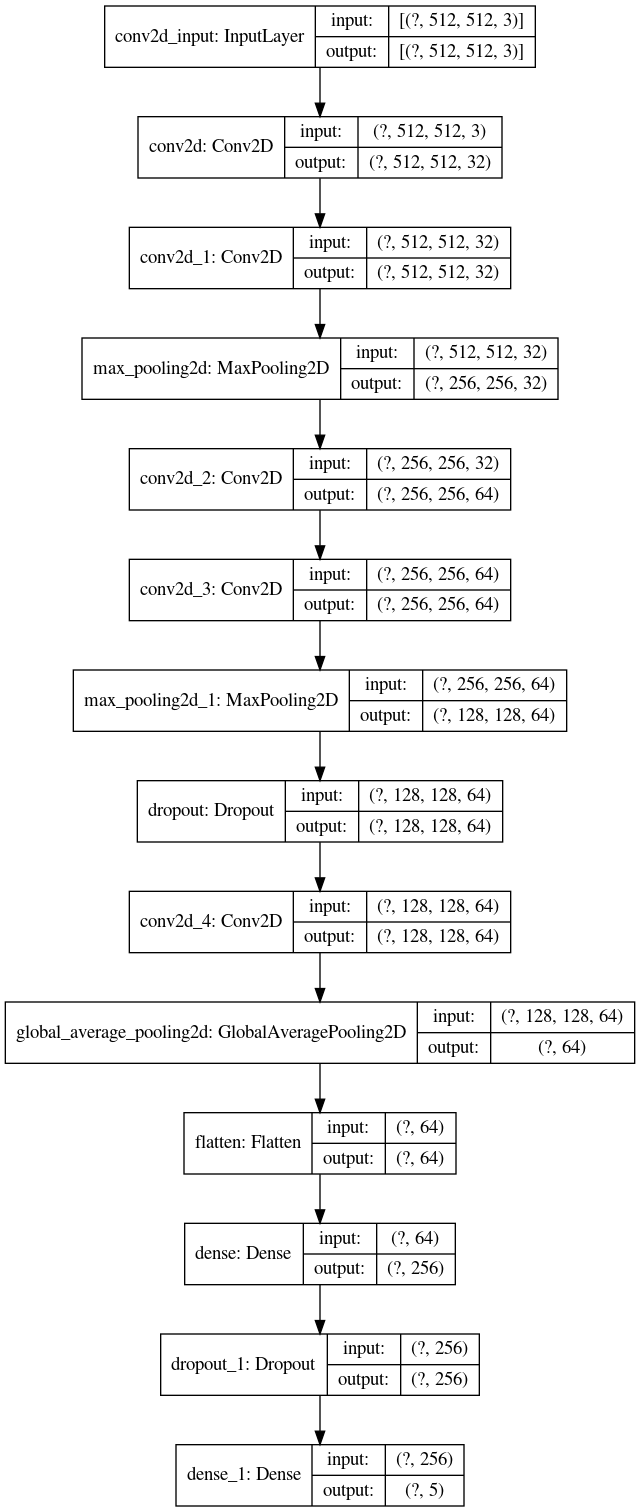

In [16]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
model_save = ModelCheckpoint('./best_baseCNN_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 4, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/32
963/962 [==============================] - ETA: 0s - loss: 1.1756 - acc: 0.6103
Epoch 00001: val_loss improved from inf to 1.06984, saving model to ./best_baseCNN_model.h5
963/962 [==============================] - 428s 444ms/step - loss: 1.1756 - acc: 0.6103 - val_loss: 1.0698 - val_acc: 0.6453
Epoch 2/32
963/962 [==============================] - ETA: 0s - loss: 1.0342 - acc: 0.6264
Epoch 00002: val_loss improved from 1.06984 to 0.99778, saving model to ./best_baseCNN_model.h5
963/962 [==============================] - 289s 300ms/step - loss: 1.0342 - acc: 0.6264 - val_loss: 0.9978 - val_acc: 0.6570
Epoch 3/32
963/962 [==============================] - ETA: 0s - loss: 1.0055 - acc: 0.6323
Epoch 00003: val_loss improved from 0.99778 to 0.92035, saving model to ./best_baseCNN_model.h5
963/962 [==============================] - 292s 303ms/step - loss: 1.0055 - acc: 0.6323 - val_loss: 0.9203 - val_acc: 0.6611
Epoch 4/32
963/962 [==============================] - ETA: 0s - loss

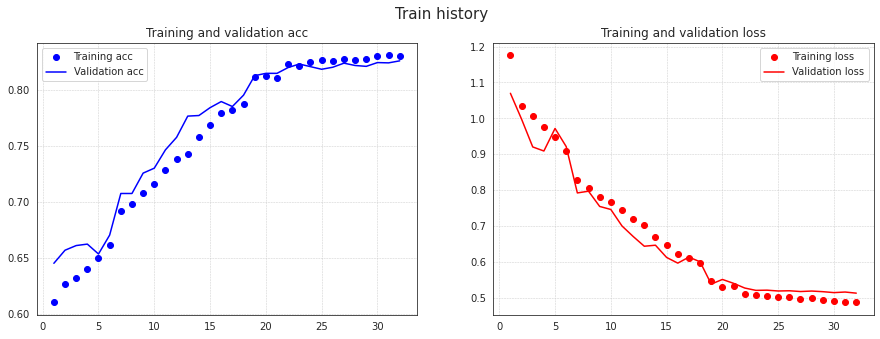

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.show()

In [19]:
model.save('./baseCNN.h5')

In [20]:
test_loss, test_accuracy =model.evaluate(test_generator)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

134/134 [==============================] - 50s 370ms/step - loss: 0.5311 - acc: 0.8117
Test loss: 0.5310964584350586, Test accuracy: 0.8116822242736816


In [21]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = test_generator.classes


accuracy = accuracy_score(true_classes , y_pred_classes)

f1 = f1_score(true_classes, y_pred_classes, average='weighted')

recall = recall_score(true_classes, y_pred_classes, average='weighted')

precision = precision_score(true_classes, y_pred_classes,average="weighted")

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:",precision)
print("F1 Score:", f1)
print(classification_report(true_classes,  y_pred_classes))

Accuracy: 0.8116822429906542
Recall: 0.8116822429906542
Precision: 0.8051962386789945
F1 Score: 0.807712896868947
              precision    recall  f1-score   support

           0       0.45      0.38      0.41        93
           1       0.71      0.65      0.68       201
           2       0.70      0.62      0.66       243
           3       0.90      0.94      0.92      1346
           4       0.59      0.61      0.60       257

    accuracy                           0.81      2140
   macro avg       0.67      0.64      0.65      2140
weighted avg       0.81      0.81      0.81      2140



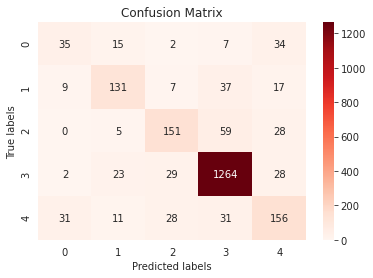

In [22]:
confu_matrix = confusion_matrix(true_classes, y_pred_classes)
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=range(0,5), yticklabels=range(0,5))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()